In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sprse
from sklearn.metrics import accuracy_score
from traitlets.config.manager import BaseJSONConfigManager
cm = BaseJSONConfigManager()
cm.update('livereveal', {
    'theme': 'sky',
    'transition': 'zoom',
    'start_slideshow_at': 'selected',
    'scroll': True
})
from final_class_ import AggregationMethods as AM
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <font color='black'> Методы и алгоритмы агрегации оценок исполнителей на краудсорсинговой платформе Toloka </font>

# <font color='black'> Александр Широков </font>



## [Toloka](https://toloka.yandex.ru/)

`Толока` — крупнейший источник размеченных людьми данных для задач машинного обучения. 

Для любых исследований и экспериментов, связанных с машинным обучением, необходимы большие объёмы качественных данных.

Раньше многие компании собирали такие оценки исключительно с помощью специально обученных сотрудников — асессоров. Но со временем задач в области машинного обучения стало слишком много, а сами задачи в массе своей перестали требовать особых знаний и опыта. Так появился спрос на помощь «толпы» (crowd). Но самостоятельно найти большое количество случайных исполнителей и работать с ними не каждому под силу. Краудсорсинговые платформы решают эту проблему.

Аналог `Amazon Mechanical Turk`.

## [Toloka Aggregation Relevance 2](https://toloka.ai/ru/datasets?turbo=true)

Исполнителю предлагался запрос и регион пользователя, который его задавал, скриншот документа и ссылка на него, возможность воспользоваться поисковыми системами и варианты ответов: 

Переформулировать

- `Релевантен` - **1**
- `Нерелевантен` - **0**
- Не отображается (не записывалось в датасет (набор данных))

[*Статья с Хабра*](https://habr.com/en/company/yandex/blog/458326/)

In [13]:
from final_class_ import AggregationMethods as AM
toloka_2 = AM(J=2, print_preview=False)
(
    toloka_2.preprocess_crowd_dataset(return_input_data=True)
    .head()
)

,worker_id,task_id,label
0,w851,t30685,1
1,w6991,t30008,0
2,w2596,t36316,0
3,w5507,t15145,1
4,w2982,t44785,1


## Оценка точности

Основной показатель качества — точность агрегированных ответов, оцениваемая на основе контрольных заданий (`голденсетов`)  набор заданий, для которых известен правильный ответ. 

In [14]:
(
    toloka_2.preprocess_golden_dataset(return_input_data=True)
    .head()
)


,task_id,label
0,t30006,0
1,t33578,0
2,t22462,1
3,t52093,0
4,t26935,0


## [Toloka Aggregation Relevance 5](https://toloka.ai/ru/datasets?turbo=true)

Этот (датасет) такой же, как предыдущий, только оценки здесь собирались не по бинарной, а по пятибалльной шкале в проекте «Релевантность (`5` градаций)»:

- `Витальный` - **5**
- `Полезный` - **4**
- `+Релевантный` - **3**
- `-Релевантный` - **2**
- `Нерелевантный` - **1**

Отличие: некоторые задания в (датасете) имеют не один, а `несколько` правильных ответов.

In [15]:
toloka_5 = AM(J=5)
(
    toloka_5.preprocess_crowd_dataset(return_input_data=True)
    .head()
)


,worker_id,task_id,label
0,w360,t186849,4
1,w43,t174611,5
2,w1040,t198665,3
3,w618,t63171,5
4,w98,t141574,5


In [16]:
(
    toloka_5.preprocess_golden_dataset(return_input_data=True)
    .head()
)


,task_id,label
0,t342646,2
1,t189317,4
2,t48377,5
3,t73830,3
4,t60415,2


## Постановка задачи

Пусть имеется $N$ сайтов $x_1, \ldots, x_n$, каждый из которых принадлежит одному из $J$ классов ${1, \ldots, J}$. 

Имеется $K$ толокеров, каждый из которых некоторым (необязательно всем) сайтам поставил в соответствие определённый класс. На входе имеем матрицу меток:

$$\large Y \in \mathbb{R}^{N \times K}$$

$$\large y_{nk} \in \{0, \ldots, J\}$$

где класс $0$ означает, что соответствующий толокер не проставил метку для сайта $n$:

**Цель**: имея ответы толокеров для каждого примера $i$ предсказать правильную метку $y_i$. Предполагается, что данная метка существует и единственна, то есть необходимо минимизировать некоторый эмпирический риск:

$$\large F = \frac{1}{N}\sum\limits_{i=1}^N \mathrm{I}(y_i \neq \hat{y}_i) \to \min$$

где $\hat{y}_i$ - предсказание метки, а $I(x)$ - индикаторная функция, возвращающая $1$, если метка истинная и $0$ - в противном случае.

## Toloka Aggregation 2: `InFo`

In [23]:
toloka_2.visual_stat()


                1. Количество сайтов: 475536.
                2. Всего размеченных сайтов: 99319.
                    - среднее количество толокеров на разметку сайта:  4.79;
                    - std: 0.69;
                    - медиана: 5.0.
                3. Количестов толокеров, выполнявших задание: 7138
                    - в среднем толокеры выполняли заданий: 66.62;
                    - std: 85.45; 
                    - медиана: 40.0. 
                4. Распределение классов на crowd датасете:
                    1: 0.58
                    0: 0.42
                5. Количество сайтов golden labels: 10079
                6. Распределение классов на golden датасете:
                    1: 0.4
                    0: 0.6
                7. Accuracy толокеров:
                    - в среднем: 63.3
                    - медиана: 66.7
                8. Средняя accuracy размеченных меток(в сравнении с golden set): 69.94%
                


c:\users\shiro\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


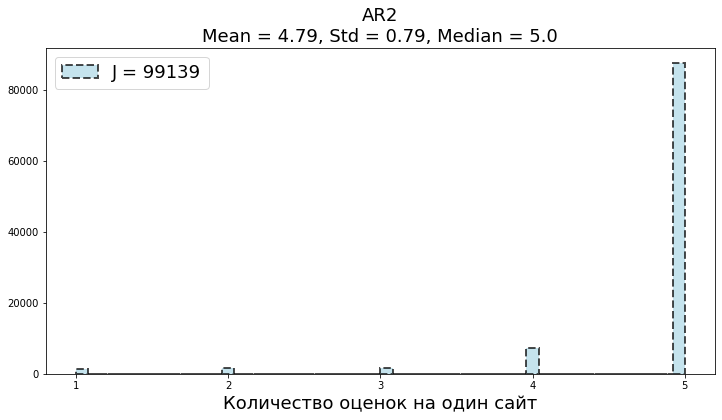

In [17]:
import seaborn as sns
dat = toloka_2.preprocess_crowd_dataset()
de = dat.groupby('task_id')['worker_id'].count()
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
sns.distplot(de.values, ax=ax, 
             hist_kws = {'color':'lightblue', 
                         'edgecolor':'black',
                         'linewidth':2, 
                         'linestyle':'--', 
                         'alpha':0.7}, 
             color='blue', kde=False, label='J = 99139')
ax.set_xlabel('Количество оценок на один сайт', fontsize=18)
ax.set_title('AR2\nMean = 4.79, Std = 0.79, Median = 5.0', fontsize=18)
ax.legend(fontsize=18)
ax.set_xticks(np.arange(1, 6))
plt.show()

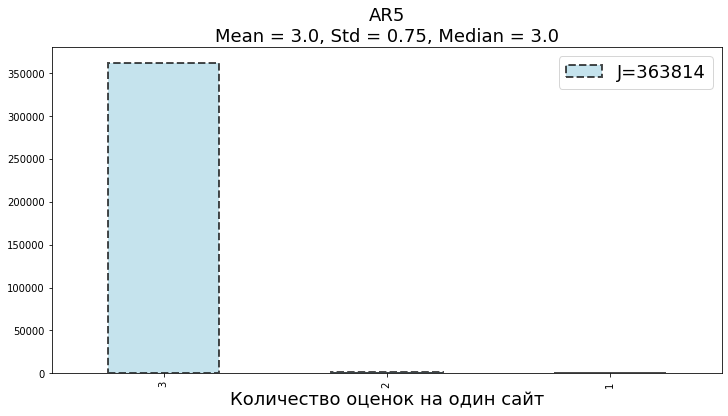

In [18]:
import seaborn as sns
dat = toloka_5.preprocess_crowd_dataset()
de = dat.groupby('task_id')['worker_id'].count()
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
pd.value_counts(de)[:3].plot.bar(color = 'lightblue', 
                                 linestyle='--', 
                                 edgecolor='black', 
                                 linewidth = 2, 
                                 alpha = 0.7, label='J=363814')
ax.set_xlabel('Количество оценок на один сайт', fontsize=18)
ax.set_title('AR5\nMean = 3.0, Std = 0.75, Median = 3.0', fontsize=18)
ax.legend(fontsize=18)
plt.show()

c:\users\shiro\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


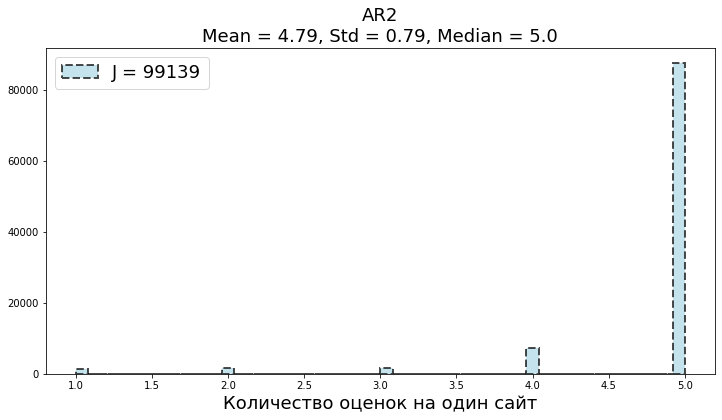

In [19]:
import seaborn as sns
dat = toloka_2.preprocess_crowd_dataset()
de = dat.groupby('task_id')['worker_id'].count()
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
sns.distplot(de.values, ax=ax, 
             hist_kws = {'color':'lightblue', 
                         'edgecolor':'black',
                         'linewidth':2, 
                         'linestyle':'--', 
                         'alpha':0.7}, 
             color='blue', kde=False, label='J = 99139')
ax.set_xlabel('Количество оценок на один сайт', fontsize=18)
ax.set_title('AR2\nMean = 4.79, Std = 0.79, Median = 5.0', fontsize=18)
ax.legend(fontsize=18)
plt.show()

In [20]:
toloka_5.visual_stat()


                1. Количество сайтов: 1091918.
                2. Всего размеченных сайтов: 363814.
                    - среднее количество толокеров на разметку сайта:  3.0;
                    - std: 0.75;
                    - медиана: 3.0.
                3. Количестов толокеров, выполнявших задание: 1273
                    - в среднем толокеры выполняли заданий: 857.75;
                    - std: 1684.48; 
                    - медиана: 198.0. 
                4. Распределение классов на crowd датасете:
                    1: 0.05
                    2: 0.01
                    3: 0.36
                    4: 0.18
                    5: 0.39
                5. Количество сайтов golden labels: 33860
                6. Распределение классов на golden датасете:
                    1: 0.12
                    2: 0.27
                    3: 0.27
                    4: 0.16
                    5: 0.19
                7. Accuracy толокеров:
                    - в среднем: 77.11%
     

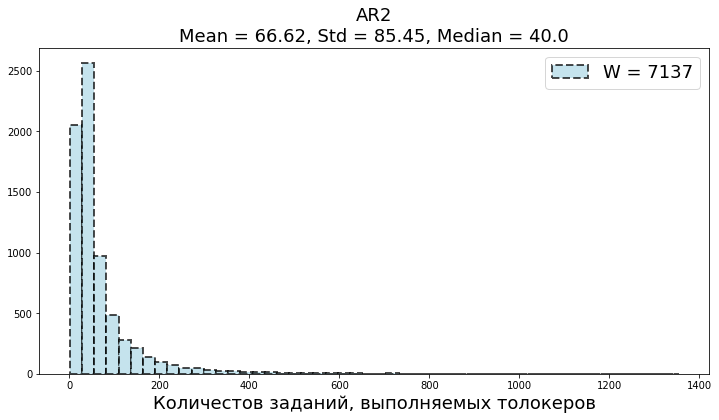

In [21]:
import seaborn as sns
dat = toloka_2.preprocess_crowd_dataset()
d = dat.groupby('worker_id')['task_id'].count()
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
sns.distplot(d.values, ax=ax, 
             hist_kws = {'color':'lightblue', 
                         'edgecolor':'black',
                         'linewidth':2, 
                         'linestyle':'--', 
                         'alpha':0.7}, 
             color='blue', kde=False, label='W = 7137')
ax.set_xlabel('Количестов заданий, выполняемых толокеров', fontsize=18)
ax.set_title('AR2\nMean = 66.62, Std = 85.45, Median = 40.0', fontsize=18)
ax.legend(fontsize=18)
plt.show()

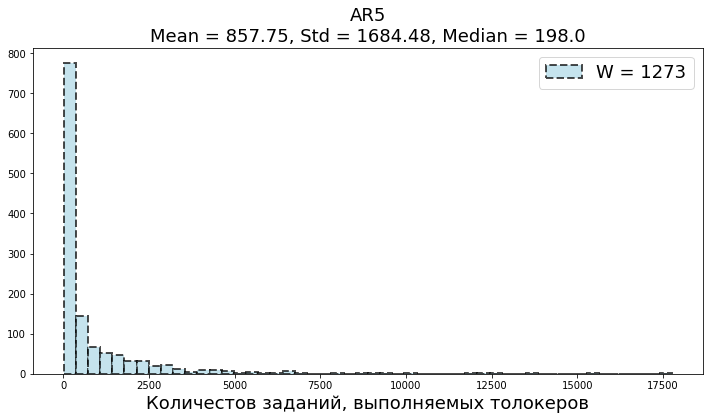

In [22]:
import seaborn as sns
dat = toloka_5.preprocess_crowd_dataset()
d = dat.groupby('worker_id')['task_id'].count()
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
sns.distplot(d.values, ax=ax, 
             hist_kws = {'color':'lightblue', 
                         'edgecolor':'black',
                         'linewidth':2, 
                         'linestyle':'--', 
                         'alpha':0.7}, 
             color='blue', kde=False, label='W = 1273')
ax.set_xlabel('Количестов заданий, выполняемых толокеров', fontsize=18)
ax.set_title('AR5\nMean = 857.75, Std = 1684.48, Median = 198.0', fontsize=18)
ax.legend(fontsize=18)
plt.show()

In [67]:
toloka_estimates = toloka_2.preprocess_crowd_dataset()
etoloka_estimates = toloka_2.preprocess_golden_dataset()
merged = pd.merge(left=toloka_estimates, 
                  right=etoloka_estimates, 
                  on='task_id', 
                  suffixes=('_pred', '_true'))
grouped = merged.groupby(by=['worker_id', 'task_id']).sum()
acc = [accuracy_score(grouped.query(f"worker_id=='{i}'").label_true.values,
                      grouped.query(f"worker_id=='{i}'").label_pred.values) 
       for i in pd.unique(np.array(list(grouped.index))[:, 0])]

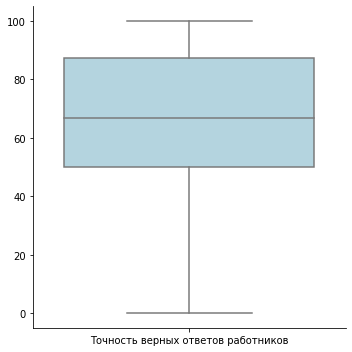

In [80]:
sns.catplot(data=pd.DataFrame(np.array(acc)*100, columns=['Точность верных ответов работников']), 
            kind='box', color = 'lightblue')
plt.show()

c:\users\shiro\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


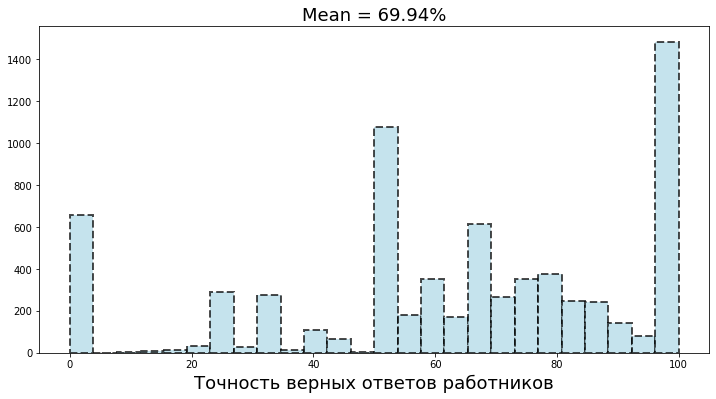

In [69]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
sns.distplot(np.array(acc) * 100, ax=ax, 
             hist_kws = {'color':'lightblue', 
                         'edgecolor':'black',
                         'linewidth':2, 
                         'linestyle':'--', 
                         'alpha':0.7}, 
             color='blue', kde=False)
ax.set_xlabel('Точность верных ответов работников', fontsize=18)
ax.set_title('Mean = 69.94%', fontsize=18)
plt.show()

## Ошибка комитета большинства

Пусть $n$ - количество работников, которые дали ответ на определённое задание, $\mu$ - `mean accuracy` $p = 1 - \mu$ - вероятность ошибки.

### Теорема 1. 

Математическое ожидание вероятности того, что как минимум $\left[\frac{n}{2}\right]$ работников выдадут правильный результат при условии, что толокеры отвечают независимо:

$$\large \mathrm{E}\left(\mathrm{P}_{\frac{n}{2}}\right) = \sum\limits_{k = \left[\frac{n}{2}\right]}^n C_n^k \mu_k (1-\mu)^{n-k}$$

Можно оценить нижнюю границу с помощью [Границы Чернова](https://neerc.ifmo.ru/wiki/index.php?title=%D0%93%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B0_%D0%A7%D0%B5%D1%80%D0%BD%D0%BE%D0%B2%D0%B0).

### Theorem 2. `Неравенство Хёфдинга`

$$ \large \mathrm{E}\left(\mathrm{P}_{\frac{n}{2}}\right) = \sum\limits_{k = \left[\frac{n}{2}\right]}^n C_n^k \geqslant 1 - e^{-2n\left(\mu - \frac{1}{2}\right)^2}$$

## Ошибка комитета большинства

Тогда из `Theorem 2`, полагая, что $1 - e^{-2n\left(\mu - \frac{1}{2}\right)^2} \geqslant C$, где $C$ - нижняя граница, что означает, что `expected accuracy` не меньше $C$, можно вывести следующий теоретический результат:

### Theorem 3.

Для заданной необходимой точности $C$ и `mean accuracy` работнико $\mu$, число работников равное:

$$\large n \geqslant \frac{-\ln (1-C)}{2\left(\mu - \frac{1}{2}\right)^2}$$

**гарантирует** (с точки зрения теории вероятностей), что ожидаемая `accuracy` будет не меньше необходимой точности $C$.


In [165]:
accuracy = np.arange(0.5, 0.99, 0.05)
n = [int(- np.log(1 - C) / (2 * (0.6994 - 1 / 2) ** 2)) for C in np.arange(0.5, 0.99, 0.05)]
dependec_workers_accuracy = pd.DataFrame.from_dict(dict(zip(accuracy, n)),  orient='index', columns=['n'])
dependec_workers_accuracy.index.name = 'Accuracy'

In [166]:
dependec_workers_accuracy.T

Accuracy,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
n,8,10,11,13,15,17,20,23,28,37


[Proof: 3.2.1](https://arxiv.org/pdf/1207.0143v1.pdf)

## Toloka Aggregation 5: `InFo`

In [11]:
toloka_5.visual_stat()


                1. Количество сайтов: 1091918.
                2. Всего размеченных сайтов: 363814.
                    - среднее количество толокеров на разметку сайта:  3.0;
                    - std: 0.75;
                    - медиана: 3.0.
                3. Количестов толокеров, выполнявших задание: 1273
                    - в среднем толокеры выполняли заданий: 857.75;
                    - std: 1684.48; 
                    - медиана: 198.0. 
                4. Распределение классов на crowd датасете:
                    1: 0.05
                    2: 0.01
                    3: 0.36
                    4: 0.18
                    5: 0.39
                5. Количество сайтов golden labels: 33860
                6. Распределение классов на golden датасете:
                    1: 0.12
                    2: 0.27
                    3: 0.27
                    4: 0.16
                    5: 0.19
                7. Accuracy толокеров:
                    - в среднем: 77.11%
     

In [12]:
accuracy = np.arange(0.5, 0.99, 0.05)
n = [int(- np.log(1 - C) / (2 * (0.843 - 1 / 2) ** 2)) for C in np.arange(0.5, 0.99, 0.05)]
dependec_workers_accuracy_5 = pd.DataFrame.from_dict(dict(zip(accuracy, n)),  orient='index', columns=['n'])
dependec_workers_accuracy_5.index.name = 'Accuracy'

In [13]:
dependec_workers_accuracy_5.T


Accuracy,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
n,2,3,3,4,5,5,6,8,9,12


# Aggregation Methods

1. Voting Ensambles

2. Averaging

3. Improved Averaging

4. EM

5. Matrix Decompositions*

## I. Voting Ensembles

### I.I Голосование по большинству (Majority vote: MV)

$$\large a(x) = \operatorname{mode}\left(b_1(x), \ldots, b_n(x)\right)$$

### I.II Комитеты единогласия в бинарной задаче классификации (UC)

$$\large a(x) = \operatorname{min}\left(b_1(x), \ldots, b_n(x)\right)$$

### I.III Обнаружение аномалий: `Mata Alghorithm` (AM)

$$\large a(x) = \operatorname{max}\left(b_1(x), \ldots, b_n(x)\right)$$

А ещё может быть `treshold commitet`.

## II. Averaging

### II.I Mean (Average)

$$ \large a(x) = \frac{1}{n}\left(b_1(x) + \ldots + b_n(x) \right)$$

### II.II [Kolmogorov averaging](https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B5_%D0%9A%D0%BE%D0%BB%D0%BC%D0%BE%D0%B3%D0%BE%D1%80%D0%BE%D0%B2%D0%B0)

$$ \large M(x_1, \ldots, x_n) = \varphi^{-1}\left(\frac{1}{n} \sum\limits_{k=1}^n \varphi(x_k)\right) =  \varphi^{-1}\left(\frac{\varphi(x_1) + \ldots + \varphi(n)}{n}\right)$$

где $\varphi$ - непрерывная строго монотонная функция, а $\varphi^{-1}$ - функция, обратная к $\varphi$. При $\varphi(x) = x$ - среднее геометрическое, при $\varphi(x) = \ln x$.

### II.III [Ручные методы ассамблирования](https://www.kaggle.com/c/amazon-employee-access-challenge) (`метод Ефимова`)


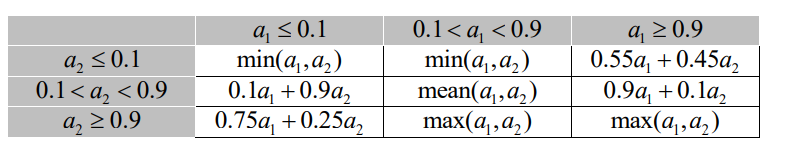

## III.  Improved Averaging

### III.I Weighted Averaging (MVA)

$$ \large a(x) = \frac{\sum\limits_{i=1}^n w_i b_i(x)}{\sum\limits_{i=1}^n w_i}$$

где $w_j$ - уровень надежности толокера, отражающий вероятность предоставить правильную метку для произволного примера.

### III.II Голосование с весами (WAWA)

$$ \large a(x) = \underset{j}{\operatorname{argmax}}\left[\sum\limits_{t: b_t(x) = j} w_t\right]$$

### III.III Bayes Wote

При известных $w_j$ - вероятностях предоставления правильного ответа, доказано, что оптимальным является байесовское голосование, где вероятность класса пропорциональна его правдоподобию:

$$\large \mathbb{P}\{y_i = c\} = \prod\limits_{j=1}^K q_j^{I(y_{ij} = c)} \left(\frac{1-q_j}{J-1}\right)^{I(y_{ij} \neq c)}$$

Оценка характеристики толокера становится основной задачей и вот почему: посмотрим на результаты работы рассмотренных алгоритмов в первой части.

**Proof**:

- [Proof 1](https://i.cs.hku.hk/~ckcheng/papers/edbt15-jury.pdf)
- [Proof 2](https://arxiv.org/pdf/1207.0143v1.pdf)

## Test Functions Toloka Aggregation 2

In [24]:
MV_2 = toloka_2.MV()
Average_2 = toloka_2.average()
UC_2 = toloka_2.UC()
AM_2 = toloka_2.AM()
MWA, mwa_wr = toloka_2.MWA()
WAWA, wawa_wr = toloka_2.WAWA()
WAWA_Bayes_Wote = toloka_2.WAWA(bayes_likelyhood=True)
WAWA_IDW, w_idw = toloka_2.WAWA(W='IDW')
WAWA_DWS, w_dws = toloka_2.WAWA(W='DWS')
WAWA_IDW, w_idw = toloka_2.WAWA(W='IDW', bayes_likelyhood=True)

2 classes: Done Majority Vote
2 classes: Done Average Vote
2 classes: Done UC
Done Alghorithm Maximise
2 classes: Done MWA
2 classes: Done Aggregation by Weights (WAWA) using W weights
Iteration 40000
Iteration 80000
2 classes: Done WAWA + Bayes(W)
2 classes: Done Aggregation by Weights (WAWA) using IDW weights
2 classes: Done Aggregation by Weights (WAWA) using DWS weights
Iteration 40000
Iteration 80000
2 classes: Done WAWA + Bayes(IDW)


In [25]:
pd.DataFrame(toloka_2.result_dict)


,MV,average,pred_UC(min),pred_AM(max),MWA,WAWA(W),WAWA + Bayes(W),WAWA(IDW),WAWA(DWS),WAWA + Bayes(IDW)
Time (s),7.664925,0.238843,0.628199,0.323794,8.817951,9.531563,320.653467,48.391266,48.219386,397.280352
Golden Accuracy (%),77.636670,76.763568,74.551047,34.527235,80.166683,80.176605,82.488342,82.458577,82.528029,83.143169


## Test Functions Toloka Aggregation 5

In [26]:
MV_5 = toloka_5.MV()
Average_5 = toloka_5.average()
MWA_5, mwa_wr_5 = toloka_5.MWA()
WAWA_5, wawa_wr_5 = toloka_5.WAWA()


5 classes: Done Majority Vote
5 classes: Done Average Vote
5 classes: Done MWA
5 classes: Done Aggregation by Weights (WAWA)


In [27]:
pd.DataFrame(toloka_5.result_dict)


,MV,pred_average,MWA,WAWA
Time (s),9.078467,2.558555,11.487422,10.544983
Golden Accuracy (%),90.135854,84.087419,90.281187,90.431187


## IV. Expectation Maximisation

Задача ставится следуюшая:

$$\ln L(X_1, \ldots, X_n \vert  \overset{\to}{\theta}) = \sum\limits_{i=1}^n \log p(x_i \vert \overset{\to}{\theta}) \to \underset{\theta}{\max}$$

Численное задача решать сложно. Поэтому примненяется EM-алгоритм. Вводятся латентные переменные: $Y_1, \ldots, Y_n \in \{0, 1\}$

`EM-Алгоритм`:

1. Подбираем начальные значения параметров $\overset{\to}{\theta}^{(0)}$

2. Expectation Step (E-step):

$$\mathbb{E}_Y \left( \overset{\sim}{L}(x_1, \ldots,x_n, Y_1, \ldots, Y_n \vert \overset{\to}{\theta}^{(0)}\right)$$

3. Maximisation Step (M-step):

$$\max E_{Y}\overset{\sim}{L} \to \overset{\to}{\theta}^{(1)}$$

4. Повторяем шаги $1-2$


## Свойство EM-Алгоритма

### Theorem 4. 

С каждым шагом процедуры `EM`-алгоритма логарифм правдоподобия **увеличивается**.

**Proof**:

$$\log L(x_1, \ldots, x_n \vert \overset{\to}{\theta}) = \sum\limits_{i=1}^n \log p(x_i \vert \theta) = \sum\limits_{i=1}^n \log \frac{P_{(X, Y)}(x_i, y_i \vert \theta)}{P_{(Y \vert X)}(y_i \vert x_i, \theta)} = $$
$$ = \sum\limits_{i=1}^n \log P_{(X, Y)}(x_i, y_i \vert \theta) - \sum\limits_{i=1}^n \log P_{(Y \vert X)}(y_i \vert x_i, \theta)$$

На каждом шаге мы переходим к оценке $\theta^{(n+1)}$:
$$\theta^{(n)} \to \theta^{(n+1)} =  \underset{\theta}{\operatorname{argmax}} E_{Y} \log L(x_,1 \ldots, x_n, Y_1, \ldots, Y_n)$$
$$\log L(x_1, \ldots, x_n \vert \theta) = E_Y \log L(x_1, \ldots, x_n, Y_1, \ldots, Y_n) - E_{Y}\sum\limits_{i=1}^n \log p_{Y \vert x}(y_i \vert x_i, \theta)$$
$$\log L(x_1, \ldots, x_n \vert \theta^{(n)}) - \log L(x_1, \ldots, x_n \vert \theta^{(n+1)}) = $$
$$E_{Y}\log L(x_1,\ldots,x_n, Y_1, \ldots, Y_n \vert \theta_n ) - E_y \log L(x_1, \ldots, x_n, y_1, \ldots, y_n) - \sum\limits_{i=1}^n E_Y \log \frac{P_{y \vert x}(Y_i \vert x_i, \theta^{(n)})}{P_{Y \vert X}(y_i \vert x_i, \theta^{(n+1)})}$$

Первая часть - меньше нуля, вторая часть - больше нуля, потому что есть метрика Кульбака-Лейблера:
$$K(f, g) = \int\limits f(x) \log \frac{f(x)}{g(x)} dx $$
$$K(f, g) \geqslant 0, K(f, g) = 0 \Leftrightarrow f = g$$

Следовательно, с каждым шагом логарифм правдоподобия будет увеличиваться. $\blacksquare$

## IV.I [Dawid Scene](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.469.1377)

Идея: будем вычислять для каждого толокера матрицу ошибок `IEE`:

$$\large \pi_{qj}^{(k)}$$

вероятность того, что толокер $k \in {1, \ldots, J}$ поставит метку $j \in \{1, \ldots, J\}$, если настоящей меткой является $q \in \{1, \ldots, J\}$.

Выпишем правдоподобие выборки в предположении, что толокеры проставляют метки независимо друг от друга. Обозначим за $p_j$ - вероятности распределения классов, $n_{il}^{(k)}$ - количество раз, которое аннтотатор поставил метку $l$ примеру $i$, а $T_{ij}, j = 1, \ldots, J$ - индикторная **латентная переменная**, $T_{iq}=1, T_{iq}=0, j \neq q$. Тогда логарифм правдоподобия:

$$\large L \sim \prod\limits_{j=1}^{J} \left\{p_j \cdot \prod\limits_{k=1}^{K}\prod\limits_{l=1}^J \left(\pi_{jl}^{(k)}\right)^{n_{il}^{(k)}}\right\}^{T_{ij}}$$

**Факт**: аналитически было найдено, что выражение для матрицы ошибок, максимизирующее функцию правдоподбия, имеет следующий вид:
$$\large \hat{\pi}_{jl}^{(k)} = \frac{\sum\limits_{i} T_{ij}n_{il}^{(k)}}{\sum\limits_i \sum\limits_j T_{ij} n_{il}^{(k)}}$$

## IV.I [Dawid Scene: EM]()

1. Давайте зададим некоторые начальные значения латентных переменных $T_{ij}$, это можно сделать либо равномерно распределенным вектором из $0$ или $1$, либо по формуле:

$$\large T_{ij}^{(0)} = \frac{\sum\limits_k n_{il}^{(k)}}{\sum\limits_k\sum\limits_l n_{il}^{(k)}}$$

2. Высчитываем параметры матрицы ошибок `IEE` и распределение классов $p_j$ в предположении о распределении латентных переменных на предыдущем шаге `EM`-алгоритма:

$$\large \hat{\pi}_{jl}^{(k)} = \frac{\sum\limits_{i} T_{ij}n_{il}^{(k)}}{\sum\limits_i \sum\limits_j T_{ij} n_{il}^{(k)}}$$

$$\large p_j = \frac{\sum\limits_{i} T_{ij}}{I}$$

### IV.I [Dawid Scene: EM]()

3. Высчитываем математические ожидание выборки с высчитанными на шаге $2$ параметрами `IIE` и `p` и получаем новое распределение латентных переменных:

$$p(T_{ij} = 1  | \text{data}) = \frac{\prod\limits_{k=1}^K \prod\limits_{l=1}^J \left(\pi_{ql}^{(k)}\right)^{n_{il}^{(k)}} \cdot p_j}{\sum\limits_{q=1}^J\prod\limits_{k=1}^K \prod\limits_{l=1}^J \left(\pi_{ql}^{(k)}\right)^{n_{il}^{(k)}} \cdot p_q}$$

4. Повторяем шаги $2-3$ до сходимости.

Итого получаем:

- вероятности $T_{ij}$ принадлежности каждого сайта определенному классу
- `worker_reliability` - надежность работников (то, что мы хотели)
    - сумма диагональных элементов / количество классов
    - взвешенный `worker_reliability` - домножаем на $p_j$ - распределение классов    

Недостатки:

- не обязательно сходится к минимуму, предположение о независимости не всегда оправдано

## Test Dawid Scene: Toloka Aggregation 2

Можно полученные веса `worker_reliability` использовать в различных взвешенных подходах, рассмотренных ранее.

Улучшения: [Fast Dawid Scene](https://arxiv.org/abs/1803.02781)

In [28]:
DS_2, worker_reliability_ds = toloka_2.DS(max_iter=10, trace=True)

---------------START ITERATION #0-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #0-----------------
---------------START ITERATION #1-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #1-----------------
---------------START ITERATION #2-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #2-----------------
---------------START ITERATION #3-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #3-----------------
---------------START ITERATION #4-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #4-----------------
---------------START ITERATION #5-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #5-----------------
---------------START ITERATION #6-----------------
start M step
done M step
start E step
done E step

In [29]:
WAWR, wr_ds = toloka_2.WAWR(worker_reliability_ds, 
                         bayes_likelyhood=False, 
                         name=' DS_Weights')

2 classes: Done WAWR


## Test Dawid Scene: Toloka Aggregation 2

Рассмотрим взвешенное аггрегирование с весами, данными работникам в результате работы алгоритма `DS`. Так же применим улучшающий `Bayes Wote`.

In [30]:
WAWR_Bayes, wr_ds_bayes = toloka_2.WAWR(worker_reliability_ds, 
                         bayes_likelyhood=True, 
                         name=' DS_Weights_Bayes')

Iteration 40000
Iteration 80000
2 classes: Done WAWA + Bayes DS_Weights_Bayes


In [31]:
pd.DataFrame(toloka_2.result_dict)

,MV,average,pred_UC(min),pred_AM(max),MWA,WAWA(W),WAWA + Bayes(W),WAWA(IDW),WAWA(DWS),WAWA + Bayes(IDW),DawidScene,WAWR,WAWA + Bayes DS_Weights_Bayes
Time (s),7.664925,0.238843,0.628199,0.323794,8.817951,9.531563,320.653467,48.391266,48.219386,397.280352,345.720450,9.090810,302.585573
Golden Accuracy (%),77.636670,76.763568,74.551047,34.527235,80.166683,80.176605,82.488342,82.458577,82.528029,83.143169,81.069551,78.073222,80.960413


## Test Dawid Scene: Toloka Aggregation 5

In [32]:
DS_5, worker_reliability_ds_5 = toloka_5.DS(max_iter=5, trace=True)

---------------START ITERATION #0-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #0-----------------
---------------START ITERATION #1-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #1-----------------
---------------START ITERATION #2-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #2-----------------
---------------START ITERATION #3-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #3-----------------
---------------START ITERATION #4-----------------
start M step
done M step
start E step
done E step
---------------END ITERATION #4-----------------
EM Done
5 classes: Done DS


In [33]:
WAWR_5, wr_ds_5 = toloka_5.WAWR(worker_reliability_ds_5, 
                         bayes_likelyhood=False, 
                         name=' DS_Weights_Bayes')

5 classes: Done WAWR


In [34]:
pd.DataFrame(toloka_5.result_dict)

,MV,pred_average,MWA,WAWA,DawidScene,WAWR
Time (s),9.078467,2.558555,11.487422,10.544983,442.434574,9.459579
Golden Accuracy (%),90.135854,84.087419,90.281187,90.431187,90.785588,90.295334


## IV.II [GLAD - Generative Model of Labels, Abilities and Difficulties](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf)

Допустим, у нас есть $n$ сайтов, каждый из которых является релевантным или нет (`1` или `0`). Мы бы хотели предсказывать `Z_j` - **правильную метку** для каждого сайта `j` при наличии голосов от `m` толокеров.

Предположим, что $Z_j$ зависит от нескольких факторов, таких как:

1. неодназначность изображения (1)

2. опыт (надежность) работника (2)

3. истинных значений `true label`

## IV.GLAD - Generative Model of Labels, Abilities and Difficulties

- **Сложность сайта** `j` будем моделировать с помощью параметра

$$\large \frac{1}{\beta_j} \in [0, \infty)$$

$\frac{1}{\beta_j}  = \infty$ означает, что непонятно, каким является сайт - релевантным или нерелевантным, и, следовательно, даже самые опытные толокеры имеют `50%` вероятность ошибиться / поставить правильную метку.

$\frac{1}{\beta_j}  = 0$ означает, что даже самый неосевдомленный толокер способен правильно оценить данный сайт

- **Надежность работника** моделируется параметром $\alpha_i \in (-\infty, +\infty)$. $\alpha_i = \infty$ означает, что работник всегда отвечает правильные ответы, а $\alpha_i = -\infty$ означает, что толокер всегда маркирует изображения неправильно (то есть он всегда может различать два класса, но всегда неправильно). В таком случае толокер называется `adversarial` - противоборствующий. Наконец, $\alpha_i = 0$ означает, что толокер не может различать два класса - его метки не содержат информации об истинной метке изображения $Z_j$. Кстати, мы не обязательно требуем, чтобы толокеры были людьми, это могут быть и классификаторы (`Logistic Regression e.t.c`)

## IV.GLAD - Generative Model of Labels, Abilities and Difficulties


Теперь идея следующая: `метки, которые выданы толокером` $i$ для `сайта ` $j$, которые мы будем называть `given labels`, обозначаются как $L_{ij}$ и будут генерироваться следующим образом:

$$\LARGE \mathbb{P}\left( L_{ij} = {Z_j} \vert \alpha_i, \beta_j \right) = \frac{1}{1 + e^{-\alpha_i \cdot \beta_j}}$$

Таким образом в данной модели логарифм отношения вероятности принадлежности классам равна билинейной функции сложности картинки и надежности толокера:

$$\LARGE \ln \frac{\mathbb{P}\left( L_{ij} = {Z_j} \right)}{1-\mathbb{P}\left( L_{ij} = {Z_j} \right)} = \alpha_i \beta_j$$

Итого, как решать задачу нахождения `правильных меток`. Неизвестными в данной модели являются `правильные метки` $Z_j$, надежность работников $\alpha_i$ и сложность сайтов $\frac{1}{\beta_j}$.

Наша цель - эффективно искать наиболее вероятные значения ненаблюдаемых переменных $Z, \alpha, \beta$ для данных. Будем использовать `Expectation Maximization` алгоритм:

## IV.GLAD - Generative Model of Labels, Abilities and Difficulties: EM

## `E-step`

Давайте обозначим все значения для сайта $j$ за $\large \textbf{l}_j = \{l_{ij'} = j' \vert j \}$. Кстати, каждый толокер не обязательно должен пометить все картинки, поэтому в данной формуле $i$ обозначает только те индексы толокеров, которые пометили данную картинку.

Нам необходоим на данном шаге посчитать вероятности меток $z_j \in \{0, 1\}$ для значения $\alpha, \beta$ с последнего шага `M`-алгоритма и переменных $l_j$:

$$\LARGE p(z_j \vert l, \alpha, \beta) = p(z_j) \cdot \prod\limits_{i=1} p(l_{ij} \vert z_j, \alpha_i, \beta_j)$$

## `M-step`

Мы максимизируем $Q$:

$$\large Q(\alpha, \beta) = E(\ln p(l, z \vert \alpha, \beta)) = \sum\limits_j E[\ln p(z_j)] + \sum\limits_{ij}E(\ln p(l_{ij} \vert z_j, \alpha_i, \beta_j)$$

Сожаление: приходится максимизировать по $\alpha$ и $\beta$, аналитического максимума нет.

## Test Realisation: GLAD

Улучшение: [модель Андрея Мищенко]() - учитывается вероятность того, что пользователь не посмотрит на задание.

In [35]:
GLAD_2 = toloka_2.GLAD(max_iter=3)

Molding data
Finished to Mold data
start M step
calculate
done M step
start E step
done M step
start M step
calculate
done M step
start E step
done M step
start M step
calculate
done M step
start E step
done M step
2 classes: Done GLAD


In [36]:
pd.DataFrame(toloka_2.result_dict)

,MV,average,pred_UC(min),pred_AM(max),MWA,WAWA(W),WAWA + Bayes(W),WAWA(IDW),WAWA(DWS),WAWA + Bayes(IDW),DawidScene,WAWR,WAWA + Bayes DS_Weights_Bayes,GLAD
Time (s),7.664925,0.238843,0.628199,0.323794,8.817951,9.531563,320.653467,48.391266,48.219386,397.280352,345.720450,9.090810,302.585573,380.537457
Golden Accuracy (%),77.636670,76.763568,74.551047,34.527235,80.166683,80.176605,82.488342,82.458577,82.528029,83.143169,81.069551,78.073222,80.960413,78.678440


## V. [Max Eigenvalue](http://www.arpitaghosh.com/papers/ecfinal-ratings.pdf)*

**Идея**: рассмотрим матрицу оценок $L$ в задаче бинарной классификации с классами ${-1,1}$. Тогда собственный вектор, соответствующий максимальному собственному значению матрицы будет являться вектором предсказаний меток.

Как?: можно посмотреть статью, я не до конца понял мотивацию.

## Final Result: Toloka Aggregation 2

In [37]:
result_toloka_2 = pd.DataFrame(toloka_2.result_dict).T
result_toloka_5 = pd.DataFrame(toloka_5.result_dict).T

In [38]:
(
    result_toloka_2['Golden Accuracy (%)']
    .sort_values(ascending=False)
    .to_frame()
)

,Golden Accuracy (%)
WAWA + Bayes(IDW),83.143169
WAWA(DWS),82.528029
WAWA + Bayes(W),82.488342
WAWA(IDW),82.458577
DawidScene,81.069551
WAWA + Bayes DS_Weights_Bayes,80.960413
WAWA(W),80.176605
MWA,80.166683
GLAD,78.678440
WAWR,78.073222


## Final Result: Toloka Aggregation 2

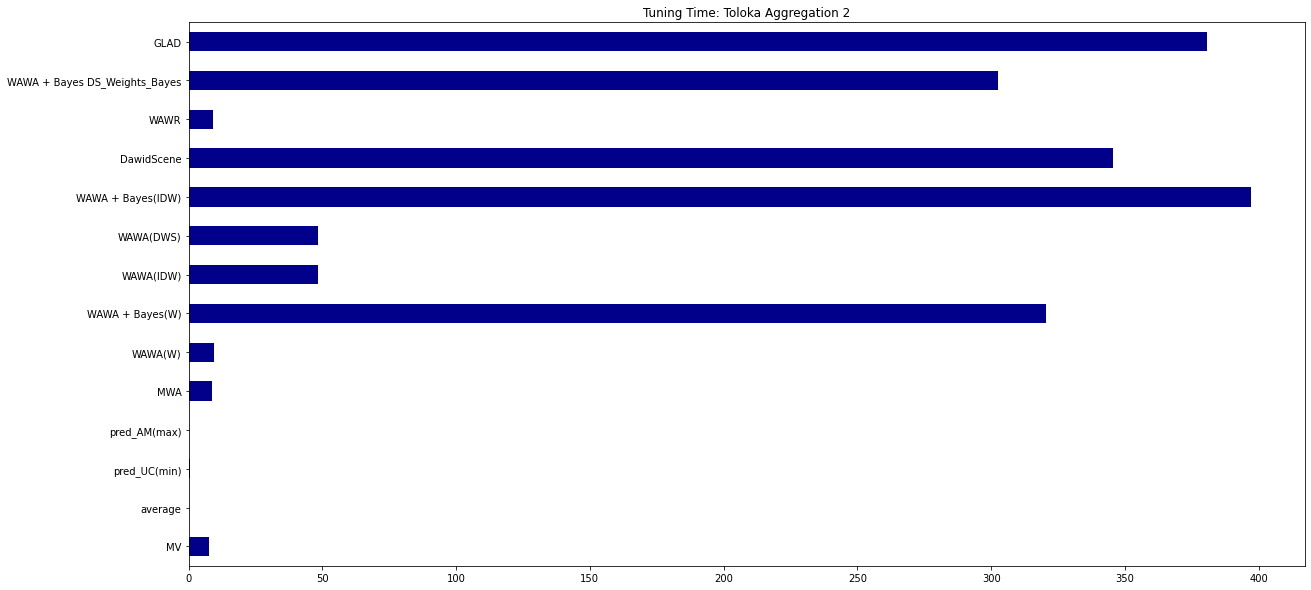

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
result_toloka_2['Time (s)'].plot.barh(color='darkblue', ax=ax)
ax.set_title('Tuning Time: Toloka Aggregation 2')
plt.show()

## Final Result: Toloka Aggregation 5

In [40]:
(
    result_toloka_5['Golden Accuracy (%)']
    .sort_values(ascending=False)
    .to_frame()
)

,Golden Accuracy (%)
DawidScene,90.785588
WAWA,90.431187
WAWR,90.295334
MWA,90.281187
MV,90.135854
pred_average,84.087419


## Final Result: Toloka Aggregation 5

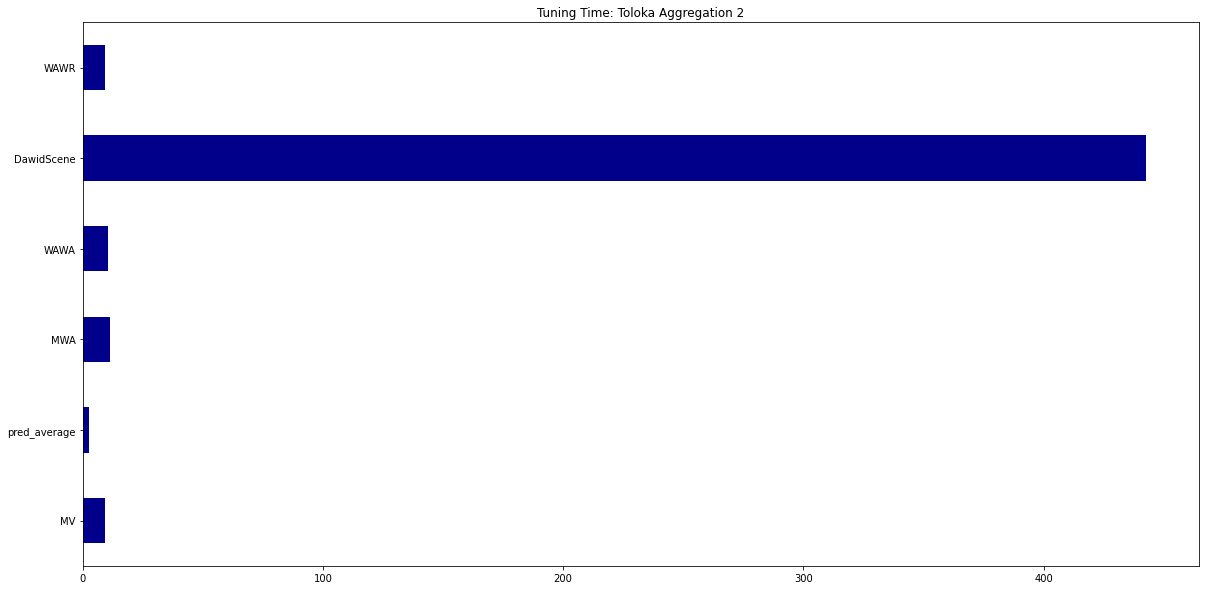

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
result_toloka_5['Time (s)'].plot.barh(color='darkblue', ax=ax)
ax.set_title('Tuning Time: Toloka Aggregation 2')
plt.show()

## Save Results

In [42]:
toloka_2.predictions.astype(int).to_csv('predict/prediction_toloka_2.csv', index=False)
toloka_5.predictions.astype(int).to_csv('predict/prediction_toloka_5.csv', index=False)

## Спасибо за внимание!